# Tabular Online Explainability with SageMaker Clarify

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

---

1. [Introduction](#Introduction)
1. [General Setup](#General-Setup)
    1. [Install dependencies](#Install-dependencies)
    1. [Import libraries](#Import-libraries)
    1. [Set configurations](#Set-configurations)
    1. [Create serializer and deserializer](#Create-serializer-and-deserializer)
    1. [For visualization](#For-visualization)
1. [Prepare data](#Prepare-data)
    1. [Download data](#Download-data)
    1. [Loading the data: Adult Dataset](#Loading-the-data:-Adult-Dataset)
    1. [Encode and Upload the Dataset](#Encode-and-Upload-the-Dataset)
1. [Train XGBoost Model](#Train-XGBoost-Model)
1. [Create endpoint](#Create-endpoint)
    1. [Create model](#Create-model)
    1. [Create endpoint config](#Create-endpoint-config)
    1. [Create endpoint](#Create-endpoint)
1. [Invoke endpoint](#Invoke-endpoint)
    1. [Single record request](#Single-record-request)
    1. [Single record request, no explanation](#Single-record-request,-no-explanation)
    1. [Batch request, explain both](#Batch-request,-explain-both)
    1. [Batch request with more records, explain some of the records](#Batch-request-with-more-records,-explain-some-of-the-records)
1. [Cleanup](#Cleanup)

## Introduction

Amazon SageMaker Clarify helps improve your machine learning models by detecting potential bias and helping explain how these models make predictions. The fairness and explainability functionality provided by SageMaker Clarify takes a step towards enabling AWS customers to build trustworthy and understandable machine learning models. 

SageMaker Clarify currently supports explainability for SageMaker models as an offline processing job. This example notebook showcases a new feature for explainability on a [SageMaker real-time inference](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html) endpoint, a.k.a. [Online Explainability](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-online-explainability.html).

This example notebook walks you through:  
1. Key terms and concepts needed to understand SageMaker Clarify
1. Training the model on a training dataset.
1. Create a model from trained model artifacts, create an endpoint configuration with the new SageMaker Clarify explainer configuration, and create an endpoint using the same explainer configuration.
1. Invoke the endpoint with single and batch request with different `EnableExplanations` query.
1. Explaining the importance of the various input features on the model's decision.


In doing so, the notebook will first train a [SageMaker XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) model using training dataset, then use SageMaker Clarify to analyze a testing dataset in CSV format.

## General Setup

We recommend you use `Python 3 (Data Science)` kernel on SageMaker Studio or `conda_python3` kernel on SageMaker Notebook Instance.

### Install dependencies

Install required dependencies. We use `shap` and `matplotlib` to visualize the feature attributions.

In [1]:
! pip install --upgrade -r requirements.txt --quiet

### Import libraries

In [2]:
import boto3
import io
import os
import pprint
import pandas as pd
import numpy as np
from sagemaker import get_execution_role, Session
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.utils import unique_name_from_base

### Set configurations

In [3]:
boto3_session = boto3.session.Session()
sagemaker_client = boto3.client("sagemaker")
sagemaker_runtime_client = boto3.client("sagemaker-runtime")

# Initialize sagemaker session
sagemaker_session = Session(
    boto_session=boto3_session,
    sagemaker_client=sagemaker_client,
    sagemaker_runtime_client=sagemaker_runtime_client,
)

region = sagemaker_session.boto_region_name
print(f"Region: {region}")

role = get_execution_role()
print(f"Role: {role}")

s3_client = boto3.client("s3")

prefix = unique_name_from_base("DEMO-Tabular-Adult")

s3_bucket = sagemaker_session.default_bucket()
s3_prefix = f"sagemaker/{prefix}"
s3_key = f"s3://{s3_bucket}/{s3_prefix}"
print(f"Demo S3 key: {s3_key}")

model_name = f"{prefix}-model"
print(f"Demo model name: {model_name}")
endpoint_config_name = f"{prefix}-endpoint-config"
print(f"Demo endpoint config name: {endpoint_config_name}")
endpoint_name = f"{prefix}-endpoint"
print(f"Demo endpoint name: {endpoint_name}")

# Instance type for training and hosting
instance_type = "ml.m5.xlarge"

Region: us-west-2
Role: arn:aws:iam::000000000000:role/service-role/SMClarifySageMaker-ExecutionRole
Demo S3 key: s3://sagemaker-us-west-2-000000000000/sagemaker/DEMO-Tabular-Adult-1686294366-1e35
Demo model name: DEMO-Tabular-Adult-1686294366-1e35-model
Demo endpoint config name: DEMO-Tabular-Adult-1686294366-1e35-endpoint-config
Demo endpoint name: DEMO-Tabular-Adult-1686294366-1e35-endpoint


### Create serializer and deserializer

CSV serializer to serialize test data to string

In [4]:
csv_serializer = CSVSerializer()

JSON deserializer to deserialize invoke endpoint response

In [5]:
json_deserializer = JSONDeserializer()

### For visualization

SHAP plots are useful visualization tools to interpret the explanations. For example, [SHAP additive force layout](https://shap.readthedocs.io/en/latest/generated/shap.plots.force.html) shows how each feature contributes to pushing the base value (also called the expected value which is the mean predictions of the training dataset) to the corresponding prediction. Features that push the prediction higher are in red color, while those push the prediction lower are in blue. We have some methods implemented for visualization in `visualization_utils.py` file.

In [6]:
%run visualization_utils.py

## Prepare data

### Download data
Data Source: [https://archive.ics.uci.edu/ml/machine-learning-databases/adult/](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/)

Let's __download__ the data and save it in the local folder with the name adult.data and adult.test from UCI repository$^{[2]}$.

$^{[2]}$Dua Dheeru, and Efi Karra Taniskidou. "[UCI Machine Learning Repository](http://archive.ics.uci.edu/ml)". Irvine, CA: University of California, School of Information and Computer Science (2017).

In [ ]:
adult_columns = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Target",
]
if not os.path.isfile("adult.data"):
    s3_client.download_file(
        f"sagemaker-example-files-prod-{region}",
        "datasets/tabular/uci_adult/adult.data",
        "adult.data",
    )
    print(f"adult.data saved!")
else:
    print(f"adult.data already on disk.")

if not os.path.isfile("adult.test"):
    s3_client.download_file(
        f"sagemaker-example-files-prod-{region}",
        "datasets/tabular/uci_adult/adult.test",
        "adult.test",
    )
    print(f"adult.test saved!")
else:
    print(f"adult.test already on disk.")

### Loading the data: Adult Dataset
From the UCI repository of machine learning datasets, this database contains 14 features concerning demographic characteristics of 45,222 rows (32,561 for training and 12,661 for testing). The task is to predict whether a person has a yearly income that is more or less than $50,000.

Here are the features and their possible values:
1. **Age**: continuous.
1. **Workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
1. **Fnlwgt**: continuous (the number of people the census takers believe that observation represents).
1. **Education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
1. **Education-num**: continuous.
1. **Marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
1. **Occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
1. **Relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
1. **Ethnic group**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
1. **Sex**: Female, Male.
    * **Note**: this data is extracted from the 1994 Census and enforces a binary option on Sex
1. **Capital-gain**: continuous.
1. **Capital-loss**: continuous.
1. **Hours-per-week**: continuous.
1. **Native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Next, we specify our binary prediction task:  
15. **Target**: <=50,000, >$50,000.

In [8]:
training_data = pd.read_csv(
    "adult.data", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?"
).dropna()

testing_data = pd.read_csv(
    "adult.test", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?", skiprows=1
).dropna()

training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Encode and Upload the Dataset
Here we encode the training and test data. Encoding input data is not necessary for SageMaker Clarify, but is necessary for the model.

In [ ]:
from sklearn import preprocessing


def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            #  print('Column:', column, result[column])
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
    return result, encoders


training_data = pd.concat([training_data["Target"], training_data.drop(["Target"], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv("train_data.csv", index=False, header=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(["Target"], axis=1)
test_target = testing_data["Target"]
test_features.to_csv("test_features.csv", index=False, header=False)

A quick note about our encoding: the "Female" Sex value has been encoded as 0 and "Male" as 1.

In [12]:
training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


Get the feature names and the label names from the dataset

In [13]:
feature_headers = testing_data.columns.to_list()
label_header = feature_headers.pop()
print(f"Feature names: {feature_headers}")
print(f"Label name: {label_header}")

Feature names: ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country']
Label name: Target


Lastly, let's upload the data to S3 so that they can be used by the training job.

In [14]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload("train_data.csv", "s3://{}/{}".format(s3_bucket, prefix))
train_input = TrainingInput(train_uri, content_type="csv")
test_uri = S3Uploader.upload("test_features.csv", "s3://{}/{}".format(s3_bucket, prefix))

## Train XGBoost Model

Since our focus is on understanding how to use SageMaker Clarify, we keep it simple by using a standard XGBoost model.

In [15]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

container = retrieve("xgboost", region, version="1.3-1")
xgb = Estimator(
    container,
    role,
    instance_count=1,
    instance_type=instance_type,
    disable_profiler=True,
    debugger_hook_config=False,
)

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)

xgb.fit({"train": train_input}, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-06-09-07-06-10-867



2023-06-09 07:06:11 Starting - Starting the training job..
2023-06-09 07:06:27 Starting - Preparing the instances for training.........
2023-06-09 07:07:21 Downloading - Downloading input data.....
2023-06-09 07:07:47 Training - Downloading the training image...
2023-06-09 07:08:07 Training - Training image download completed. Training in progress.....
2023-06-09 07:08:33 Uploading - Uploading generated training model.
2023-06-09 07:08:44 Completed - Training job completed


Create a new model object which will be used to create the SageMaker model.

In [16]:
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
container_def

{'Image': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.3-1',
 'Environment': {},
 'ModelDataUrl': 's3://sagemaker-us-west-2-000000000000/sagemaker-xgboost-2023-06-09-07-06-10-867/output/model.tar.gz'}

## Create endpoint

### Create model

The following parameters are required to create a SageMaker model:

* `ExecutionRoleArn`: The ARN of the IAM role that Amazon SageMaker can assume to access the model artifacts/ docker images for deployment

* `ModelName`: name of the SageMaker model.

* `PrimaryContainer`: The location of the primary docker image containing inference code, associated artifacts, and custom environment map that the inference code uses when the model is deployed for predictions.

In [17]:
sagemaker_client.create_model(
    ExecutionRoleArn=role,
    ModelName=model_name,
    PrimaryContainer=container_def,
)
print(f"Model created: {model_name}")

Model created: DEMO-Tabular-Adult-1686294366-1e35-model


### Create endpoint config

Create an endpoint configuration by calling the `create_endpoint_config` API. Here, supply the same `model_name` used in the `create_model` API call. The `create_endpoint_config` now supports the additional parameter `ClarifyExplainerConfig` to enable the Clarify explainer. The SHAP baseline is mandatory, it can be provided either as inline baseline data (the `ShapBaseline` parameter) or by a S3 baseline file (the `ShapBaselineUri` parameter). Baseline dataset type shall be the same as input dataset type, and baseline samples shall only include features. For more details on baseline selection please [refer this documentation](https://docs.aws.amazon.com/en_us/sagemaker/latest/dg/clarify-feature-attribute-shap-baselines.html).

Please see [the API documentation](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateEndpointConfig.html) for details on other config parameters.

In [18]:
baseline = test_features.mean().to_list()  # Inline baseline data
print(f"Use the mean of the test data as the SHAP baseline: {baseline}")

Use the mean of the test data as the SHAP baseline: [38.76832669322709, 2.2148738379814077, 189616.37025232404, 10.272377158034528, 10.112749003984064, 2.5952855245683932, 5.989043824701195, 1.401394422310757, 3.6836653386454183, 0.6737715803452855, 1120.301593625498, 89.04189907038513, 40.951593625498006, 35.4675962815405]


In [19]:
sagemaker_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "TestVariant",
            "ModelName": model_name,
            "InitialInstanceCount": 1,
            "InstanceType": instance_type,
        }
    ],
    ExplainerConfig={
        "ClarifyExplainerConfig": {
            # "EnableExplanations": "`false`",  # By default explanations are enabled, but you can change the condition by this parameter.
            "InferenceConfig": {
                "FeatureHeaders": feature_headers,
            },
            "ShapConfig": {
                "ShapBaselineConfig": {
                    "ShapBaseline": csv_serializer.serialize(baseline),  # inline baseline data
                }
            },
        }
    },
)

{'EndpointConfigArn': 'arn:aws:sagemaker:us-west-2:000000000000:endpoint-config/demo-tabular-adult-1686294366-1e35-endpoint-config',
 'ResponseMetadata': {'RequestId': 'f413c1f7-561f-4577-84c2-54ab7aaa83dc',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f413c1f7-561f-4577-84c2-54ab7aaa83dc',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '131',
   'date': 'Fri, 09 Jun 2023 07:08:47 GMT'},
  'RetryAttempts': 0}}

### Create endpoint

Once you have your model and endpoint configuration ready, use the `create_endpoint` API to create your endpoint. The `endpoint_name` must be unique within an AWS Region in your AWS account. The `create_endpoint` API is synchronous in nature and returns an immediate response with the endpoint status being `Creating` state.

In [20]:
sagemaker_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
)

{'EndpointArn': 'arn:aws:sagemaker:us-west-2:000000000000:endpoint/demo-tabular-adult-1686294366-1e35-endpoint',
 'ResponseMetadata': {'RequestId': '9bd0678a-8792-4482-ba11-851fb84851ae',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '9bd0678a-8792-4482-ba11-851fb84851ae',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '111',
   'date': 'Fri, 09 Jun 2023 07:08:48 GMT'},
  'RetryAttempts': 0}}

Wait for the endpoint to be in "InService" state.

In [21]:
sagemaker_session.wait_for_endpoint(endpoint_name)

----!

{'EndpointName': 'DEMO-Tabular-Adult-1686294366-1e35-endpoint',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:000000000000:endpoint/demo-tabular-adult-1686294366-1e35-endpoint',
 'EndpointConfigName': 'DEMO-Tabular-Adult-1686294366-1e35-endpoint-config',
 'ProductionVariants': [{'VariantName': 'TestVariant',
   'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.3-1',
     'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:d9deabb1be8135a1adee48079d2b6c8cc449c91270c2ead09b1ae80faef1914f',
     'ResolutionTime': datetime.datetime(2023, 6, 9, 7, 8, 49, 655000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 6, 9, 7, 8, 49, 147000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 6, 9, 7, 10, 58, 162000, tzinfo=tzlocal()),
 'Explain

## Invoke endpoint

There are expanding business needs and legislative regulations that require explanations of _why_ a model made the decision it did. SageMaker Clarify uses SHAP to explain the contribution that each input feature makes to the final decision.

Below are the several different combination of endpoint invocation, call them one by one and visualize the explanations by running the subsequent cell. 

### Single record request

Put only one record in the request body, and then send the request to the endpoint to get its predictions and explanations.

In [22]:
request_records = test_features.iloc[:1, :]
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    Body=csv_serializer.serialize(request_records.to_numpy()),
)
pprint.pprint(response)

{'Body': <botocore.response.StreamingBody object at 0x7fa873edd8d0>,
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'TestVariant',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '1391',
                                      'content-type': 'application/json',
                                      'date': 'Fri, 09 Jun 2023 07:11:20 GMT',
                                      'x-amzn-invoked-production-variant': 'TestVariant',
                                      'x-amzn-requestid': 'd0c4f3a0-13ad-4344-8557-b3f476e48e42'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'd0c4f3a0-13ad-4344-8557-b3f476e48e42',
                      'RetryAttempts': 0}}


Print the response body which is JSON. Please see the developer guide for its schema.

In [23]:
result = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
pprint.pprint(result)

{'explanations': {'kernel_shap': [[{'attributions': [{'attribution': [-0.002863750863790409]}],
                                    'feature_header': 'Age'},
                                   {'attributions': [{'attribution': [-7.958259263737853e-05]}],
                                    'feature_header': 'Workclass'},
                                   {'attributions': [{'attribution': [-0.0005799106931207973]}],
                                    'feature_header': 'fnlwgt'},
                                   {'attributions': [{'attribution': [7.400679338294426e-05]}],
                                    'feature_header': 'Education'},
                                   {'attributions': [{'attribution': [-0.0011474692113115962]}],
                                    'feature_header': 'Education-Num'},
                                   {'attributions': [{'attribution': [-0.0010910584437894126]}],
                                    'feature_header': 'Marital Status'},
            

Use SHAP plots to visualize the result. [SHAP additive force layout](https://shap.readthedocs.io/en/latest/generated/shap.plots.force.html) shows how each feature contributes to pushing the base value (also called the expected value which is the mean predictions of the training dataset) to the corresponding prediction. Features that push the prediction higher are in red color, while those push the prediction lower are in blue.

The expected value is the average of the model predictions over the baseline. Here we predict the baseline data and then compute the expected value. Only the predictions are needed, so the `EnableExplanations` parameter is used to disable the explanations.

In [24]:
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    Body=csv_serializer.serialize(baseline),
    EnableExplanations="`false`",  # Do not provide explanations
)
json_object = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
expected_value = float(
    pd.read_csv(io.StringIO(json_object["predictions"]["data"]), header=None)
    .astype(float)
    .mean(axis=1)
)
print(f"expected value: {expected_value}")

expected value: 0.0028374067042022


Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


Model Inference output: 
Record: 1	Model Prediction: 0.0006380207487381
Visualize the SHAP values for Record number 1 with Model Prediction: 0.0006380207487381


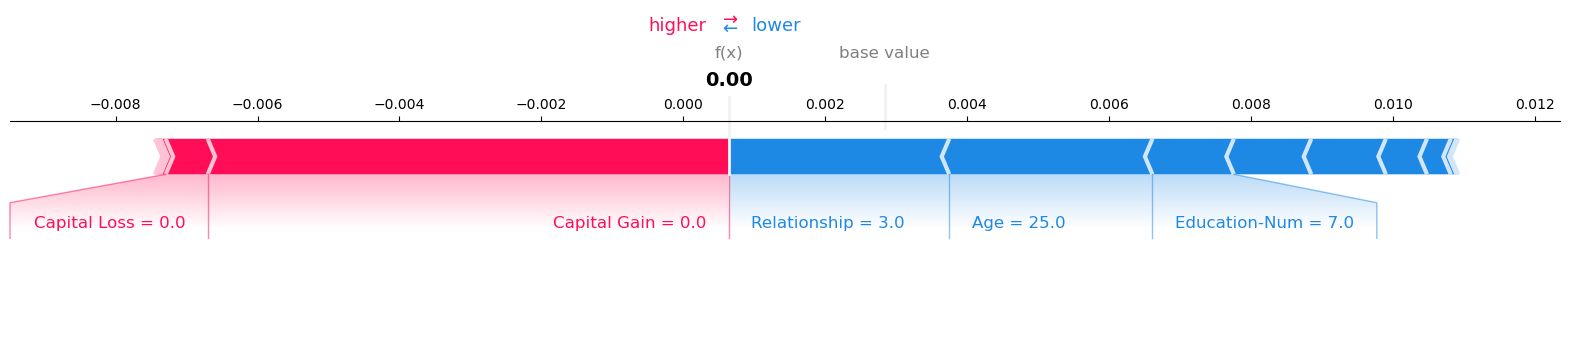

In [25]:
visualize_result(result, request_records, expected_value)

### Single record request, no explanation

Use the `EnableExplanations` parameter to disable the explanations for this request.

In [26]:
request_records = test_features.iloc[:1, :]
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    Body=csv_serializer.serialize(request_records.to_numpy()),
    EnableExplanations="`false`",  # Do not provide explanations
)
result = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
pprint.pprint(result)

{'explanations': {},
 'predictions': {'content_type': 'text/csv; charset=utf-8',
                 'data': '0.0006380207487381995\n'},
 'version': '1.0'}


In [27]:
visualize_result(result, request_records, expected_value)

Model Inference output: 
Record: 1	Model Prediction: 0.0006380207487381
No Clarify explanations for the record(s)


### Batch request, explain both

Put two records in the request body, and then send the request to the endpoint to get their predictions and explanations.

In [28]:
request_records = test_features.iloc[:2, :]
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    Body=csv_serializer.serialize(request_records.to_numpy()),
)
result = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
pprint.pprint(result)

{'explanations': {'kernel_shap': [[{'attributions': [{'attribution': [-0.002949592623471876]}],
                                    'feature_header': 'Age'},
                                   {'attributions': [{'attribution': [9.292116176143873e-05]}],
                                    'feature_header': 'Workclass'},
                                   {'attributions': [{'attribution': [-0.0006494697445634267]}],
                                    'feature_header': 'fnlwgt'},
                                   {'attributions': [{'attribution': [4.697105974365071e-05]}],
                                    'feature_header': 'Education'},
                                   {'attributions': [{'attribution': [-0.0010410828803403037]}],
                                    'feature_header': 'Education-Num'},
                                   {'attributions': [{'attribution': [-0.0010605378944009967]}],
                                    'feature_header': 'Marital Status'},
             

Model Inference output: 
Record: 1	Model Prediction: 0.0006380207487381
Record: 2	Model Prediction: 0.1621972769498825
Visualize the SHAP values for Record number 1 with Model Prediction: 0.0006380207487381


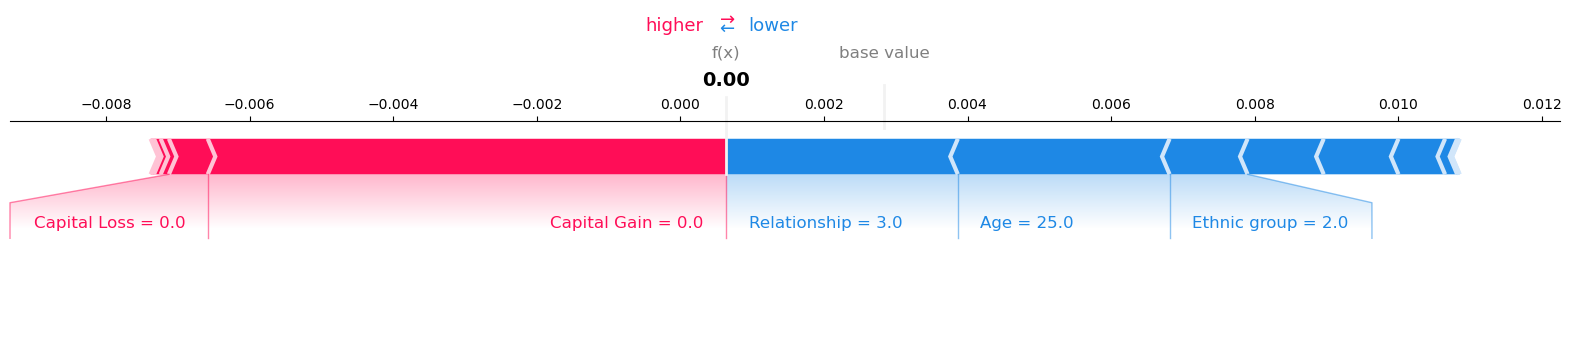

Visualize the SHAP values for Record number 2 with Model Prediction: 0.1621972769498825


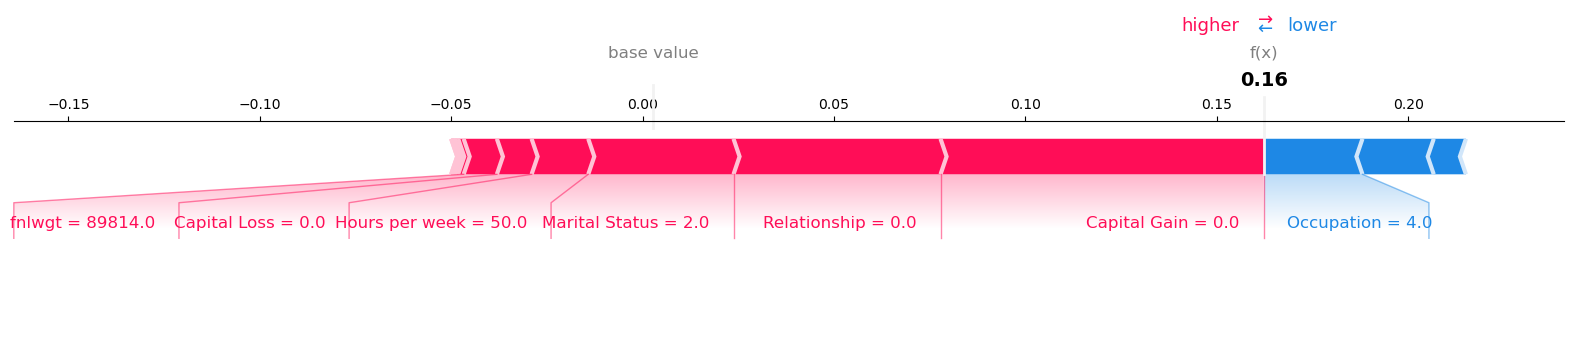

In [29]:
visualize_result(result, request_records, expected_value)

In [30]:
request_records = test_features.iloc[:2, :]
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    Body=csv_serializer.serialize(request_records.to_numpy()),
    EnableExplanations="`false`",  # Do not provide explanations
)
result = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
pprint.pprint(result)

{'explanations': {},
 'predictions': {'content_type': 'text/csv; charset=utf-8',
                 'data': '0.0006380207487381995\n0.1621972769498825\n'},
 'version': '1.0'}


In [31]:
visualize_result(result, request_records, expected_value)

Model Inference output: 
Record: 1	Model Prediction: 0.0006380207487381
Record: 2	Model Prediction: 0.1621972769498825
No Clarify explanations for the record(s)


### Batch request with more records, explain some of the records

Put a few more records to the request body, and then use the `EnableExplanations` expression to filter the records to be explained according to their predictions.

In [32]:
request_records = test_features.iloc[:70, :]
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    Body=csv_serializer.serialize(request_records.to_numpy()),
    EnableExplanations="[0]>`0.95`",  # Explain a record only when its prediction is greater than the threshold
)
result = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
pprint.pprint(result)

{'explanations': {'kernel_shap': [None,
                                  None,
                                  None,
                                  [{'attributions': [{'attribution': [0.006114497519667782]}],
                                    'feature_header': 'Age'},
                                   {'attributions': [{'attribution': [0.0003501730095504252]}],
                                    'feature_header': 'Workclass'},
                                   {'attributions': [{'attribution': [0.0012082672336744121]}],
                                    'feature_header': 'fnlwgt'},
                                   {'attributions': [{'attribution': [-0.0026339170191323202]}],
                                    'feature_header': 'Education'},
                                   {'attributions': [{'attribution': [-0.0005213645642889592]}],
                                    'feature_header': 'Education-Num'},
                                   {'attributions': [{'attributi

Model Inference output: 
Record: 1	Model Prediction: 0.0006380207487381
Record: 2	Model Prediction: 0.1621972769498825
Record: 3	Model Prediction: 0.3054092824459076
Record: 4	Model Prediction: 0.9972025156021118
Record: 5	Model Prediction: 0.00134762970265
Record: 6	Model Prediction: 0.970222532749176
Record: 7	Model Prediction: 0.0024346690624952
Record: 8	Model Prediction: 0.010292550548911
Record: 9	Model Prediction: 0.8399405479431152
Record: 10	Model Prediction: 0.5122696161270142
Record: 11	Model Prediction: 0.0018374125938862
Record: 12	Model Prediction: 0.9031689763069152
Record: 13	Model Prediction: 0.9002657532691956
Record: 14	Model Prediction: 4.049914423376322e-05
Record: 15	Model Prediction: 0.2410493195056915
Record: 16	Model Prediction: 0.0014137822436168
Record: 17	Model Prediction: 0.5082170367240906
Record: 18	Model Prediction: 0.0010446715168654
Record: 19	Model Prediction: 0.0458378717303276
Record: 20	Model Prediction: 0.1906164437532425
Record: 21	Model Predicti

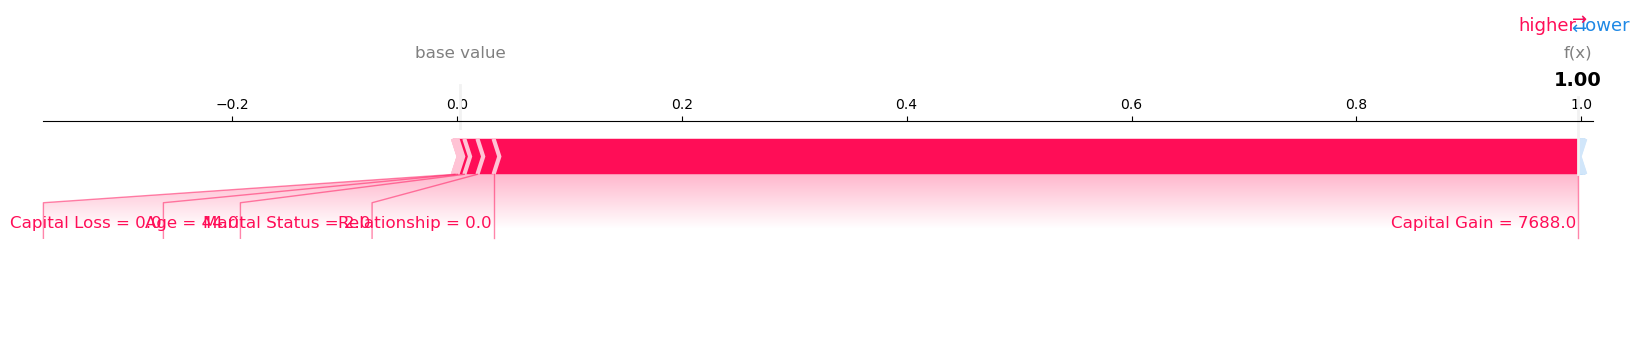

Visualize the SHAP values for Record number 6 with Model Prediction: 0.970222532749176


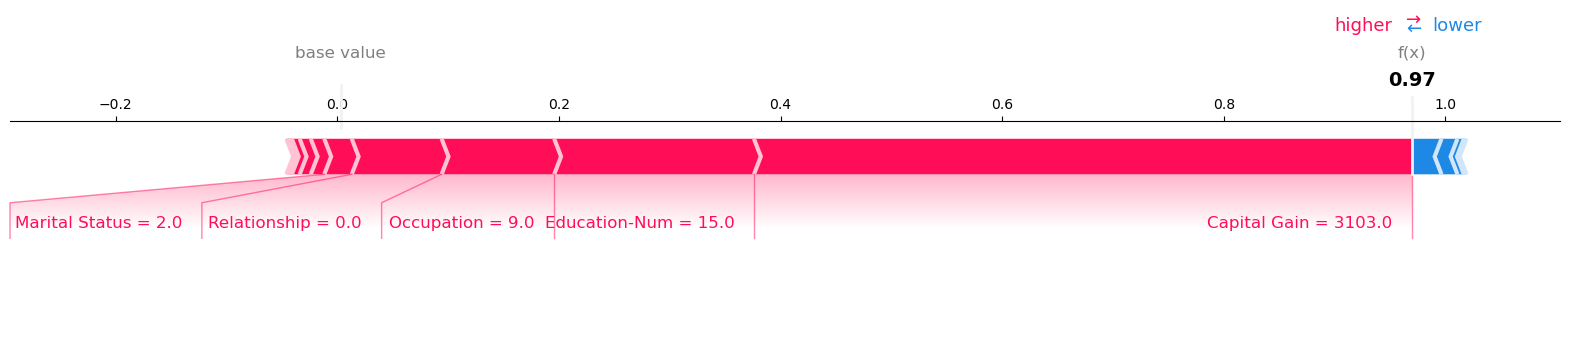

Visualize the SHAP values for Record number 21 with Model Prediction: 0.9927980899810792


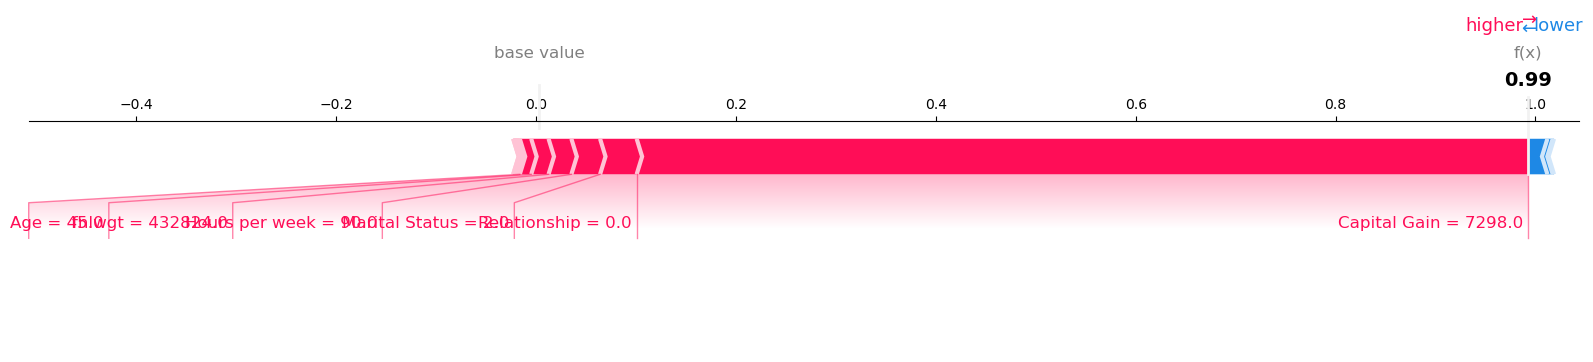

Visualize the SHAP values for Record number 26 with Model Prediction: 0.9933143258094788


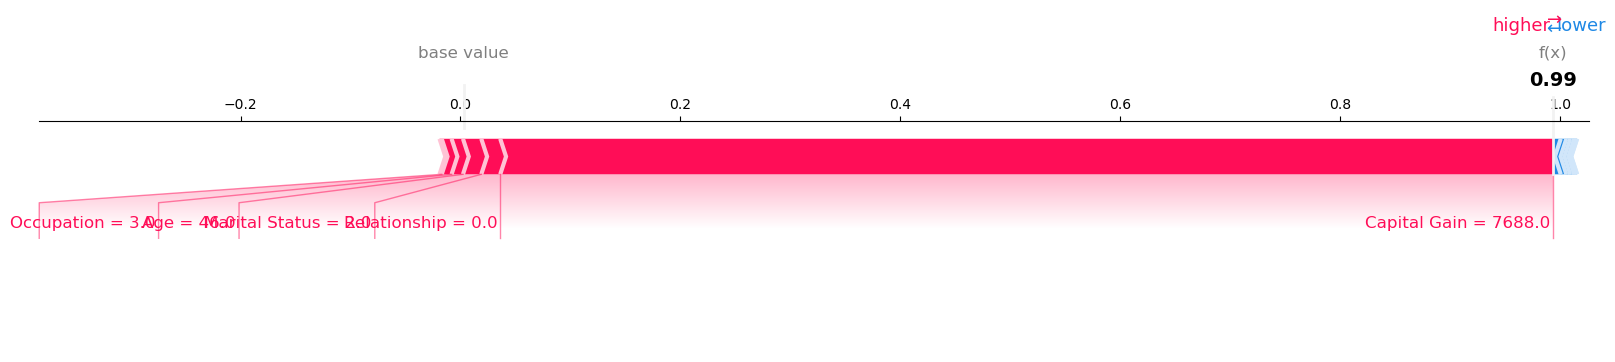

Visualize the SHAP values for Record number 52 with Model Prediction: 0.9673966765403748


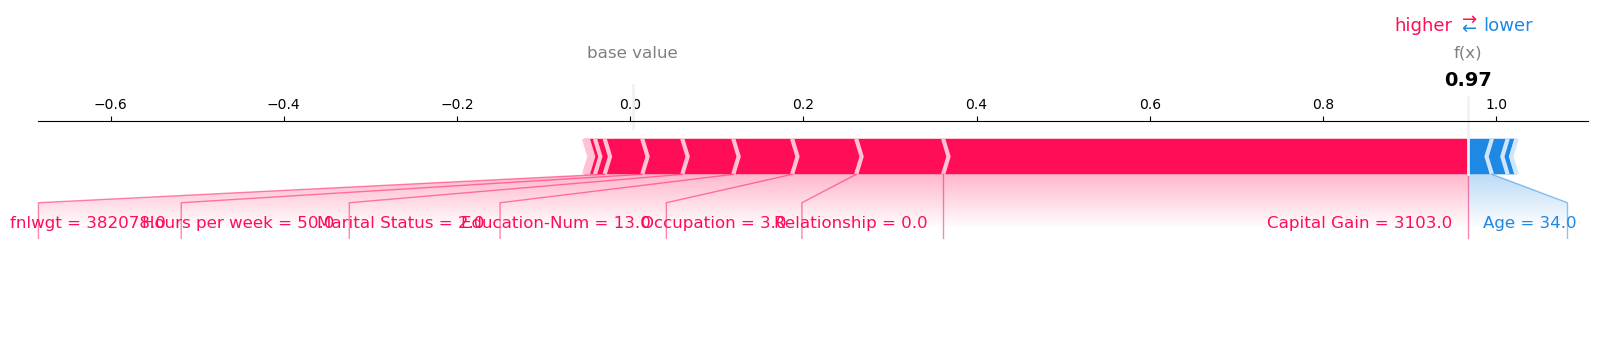

Visualize the SHAP values for Record number 53 with Model Prediction: 0.9782292246818542


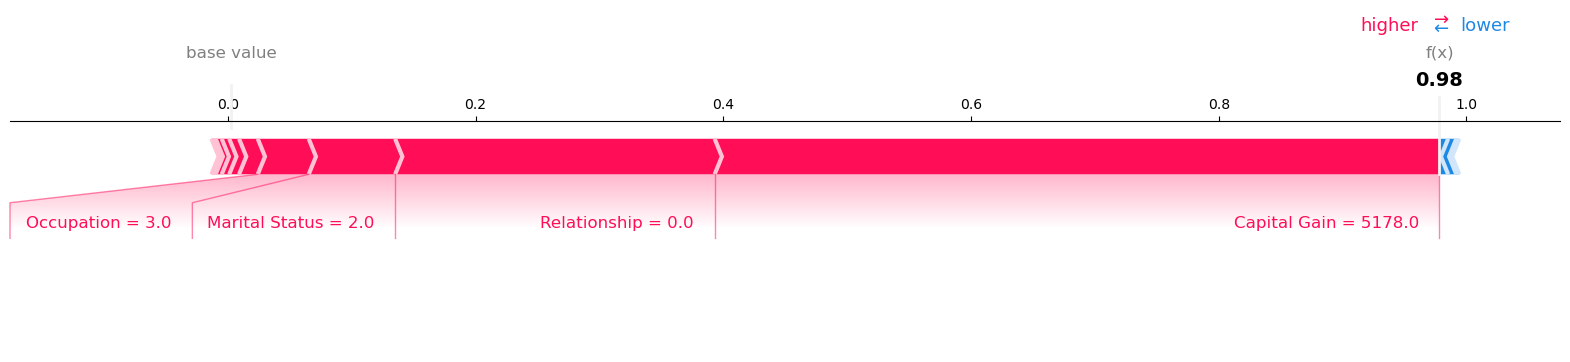

Visualize the SHAP values for Record number 60 with Model Prediction: 0.997665286064148


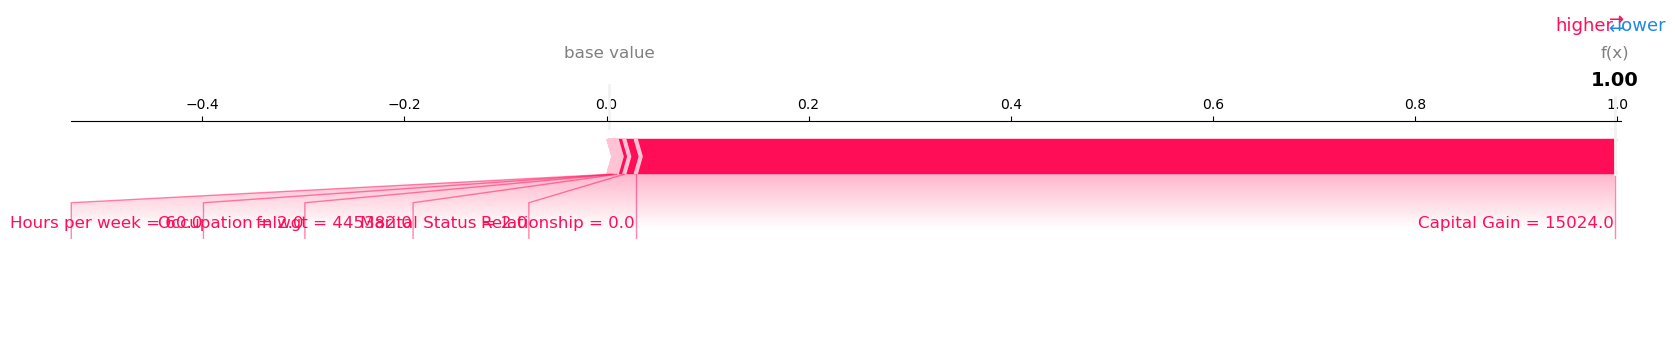

Visualize the SHAP values for Record number 64 with Model Prediction: 0.9987672567367554


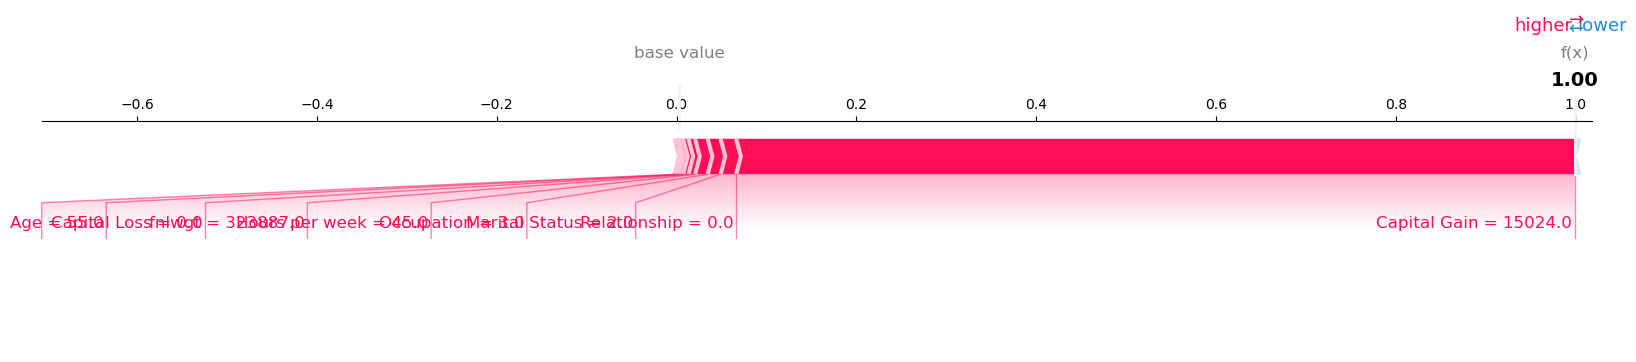

In [33]:
visualize_result(result, request_records, expected_value)

## Cleanup

Finally, don’t forget to clean up the resources we set up and used for this demo!

In [ ]:
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

In [ ]:
sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

In [ ]:
sagemaker_client.delete_model(ModelName=model_name)

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/responsible_ai|sm-clarify_online_explainability_tabular|sm-clarify_online_explainability_tabular.ipynb)
